# AutoEncoder

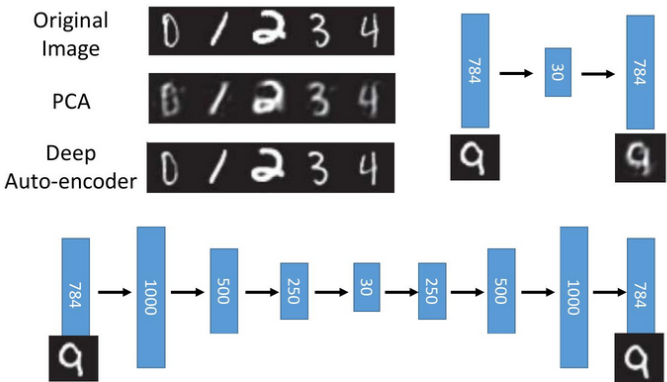

model is on: cuda:0



(dot.exe:10652): Pango-WARNING **: couldn't load font "Linux libertine Not-Rotated 10", falling back to "Sans Not-Rotated 10", expect ugly output.


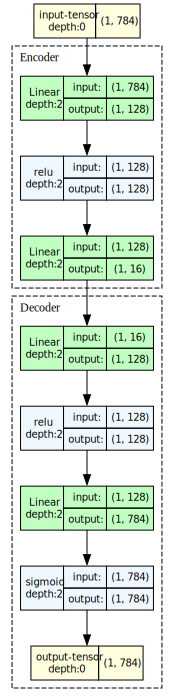

In [1]:
"""
AE on mnist
"""
import torch
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch import nn, optim
from torch.nn import functional as F
from tqdm import tqdm
import os

'模型结构'
class Encoder(torch.nn.Module):
    #编码器，将input_size维度数据压缩为latent_size维度
    def __init__(self, input_size, hidden_size, latent_size):
        super(Encoder, self).__init__()
        self.linear1 = nn.Linear(input_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, latent_size)

    def forward(self, x):# x: bs,input_size
        x = F.relu(self.linear1(x)) #-> bs,hidden_size
        x = self.linear2(x) #-> bs,latent_size
        return x

class Decoder(torch.nn.Module):
    #解码器，将latent_size维度的压缩数据转换为output_size维度的数据
    def __init__(self, latent_size, hidden_size, output_size):
        super(Decoder, self).__init__()
        self.linear1 = torch.nn.Linear(latent_size, hidden_size)
        self.linear2 = torch.nn.Linear(hidden_size, output_size)        

    def forward(self, x): # x:bs,latent_size
        x = F.relu(self.linear1(x)) #->bs,hidden_size
        x = torch.sigmoid(self.linear2(x)) #->bs,output_size
        return x

class AE(torch.nn.Module):
    #将编码器解码器组合，数据先后通过编码器、解码器处理
    def __init__(self, input_size, output_size, latent_size, hidden_size):
        super(AE, self).__init__()
        self.encoder = Encoder(input_size, hidden_size, latent_size)
        self.decoder = Decoder(latent_size, hidden_size, output_size)
    def forward(self, x): #x: bs,input_size
        feat = self.encoder(x) #feat: bs,latent_size
        re_x = self.decoder(feat) #re_x: bs, output_size
        return re_x

#损失函数
#交叉熵，衡量各个像素原始数据与重构数据的误差
loss_BCE = torch.nn.BCELoss(reduction = 'sum')
#均方误差可作为交叉熵替代使用.衡量各个像素原始数据与重构数据的误差
loss_MSE = torch.nn.MSELoss(reduction = 'sum')

'超参数及构造模型'
#模型参数
latent_size =16 #压缩后的特征维度
hidden_size = 128 #encoder和decoder中间层的维度
input_size= output_size = 28*28 #原始图片和生成图片的维度

#训练参数
epochs = 5 #训练轮次
batch_size = 32 #每步训练样本数
learning_rate = 1e-3 #学习率
device =torch.device('cuda' if torch.cuda.is_available() else 'cpu')#训练设备

#确定模型，导入已训练模型（如有）
modelname = 'ae.pth'
model = AE(input_size,output_size,latent_size,hidden_size).to(device)

from torchview import draw_graph

device = next(model.parameters()).device
print('model is on:', device)

batch_size = 1
model_graph = draw_graph(model, input_size=(batch_size, 28*28), expand_nested=True) # device='meta', 
model_graph.visual_graph

In [2]:

optimizer = optim.Adam(model.parameters(), lr=learning_rate)

load_success = False
try:
    model = torch.load(modelname)
    print('[INFO] Load Model complete')
    load_success = True
except:
    pass

if not load_success:
    
    '训练模型'
    #准备mnist数据集 (数据会下载到py文件所在的data文件夹下)
    train_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=True, download=True,
                       transform=transforms.ToTensor()),
        batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=False, transform=transforms.ToTensor()),
        batch_size=batch_size, shuffle=False)
    #此方法获取的数据各像素值范围0-1
    
    #训练及测试
    loss_history = {'train':[],'eval':[]}
    
    for epoch in range(epochs):   
        #训练
        model.train()
        #每个epoch重置损失，设置进度条
        train_loss = 0
        train_nsample = 0
        t = tqdm(train_loader,desc = f'[train]epoch:{epoch}')
        for imgs, lbls in t: #imgs:(bs,28,28)
            bs = imgs.shape[0]
            #获取数据
            imgs = imgs.to(device).view(bs,input_size) #imgs:(bs,28*28)
            #模型运算     
            re_imgs = model(imgs)
            #计算损失
            loss = loss_BCE(re_imgs, imgs) # 重构与原始数据的差距(也可使用loss_MSE)
            #反向传播、参数优化，重置
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            #计算平均损失，设置进度条
            train_loss += loss.item()
            train_nsample += bs
            t.set_postfix({'loss':train_loss/train_nsample})
        #每个epoch记录总损失
        loss_history['train'].append(train_loss/train_nsample)
    
        #测试
        model.eval()
        #每个epoch重置损失，设置进度条
        test_loss = 0
        test_nsample = 0
        e = tqdm(test_loader,desc = f'[eval]epoch:{epoch}')
        for imgs, label in e:
            bs = imgs.shape[0]
            #获取数据
            imgs = imgs.to(device).view(bs,input_size)
            #模型运算   
            re_imgs = model(imgs)
            #计算损失
            loss = loss_BCE(re_imgs, imgs) 
            #计算平均损失，设置进度条
            test_loss += loss.item()
            test_nsample += bs
            e.set_postfix({'loss':test_loss/test_nsample})
        #每个epoch记录总损失    
        loss_history['eval'].append(test_loss/test_nsample)
    
    #显示每个epoch的loss变化
    plt.plot(range(epoch+1),loss_history['train'])
    plt.plot(range(epoch+1),loss_history['eval'])
    plt.title("epoch " + str(epoch))
    plt.show()
    
    #存储模型
    torch.save(model,modelname)

[INFO] Load Model complete


C:\Users\eleve\AppData\Local\Temp\ipykernel_11332\1352996644.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(modelname)


torch.Size([1, 784]) -> torch.Size([1, 16])


<Figure size 600x200 with 0 Axes>

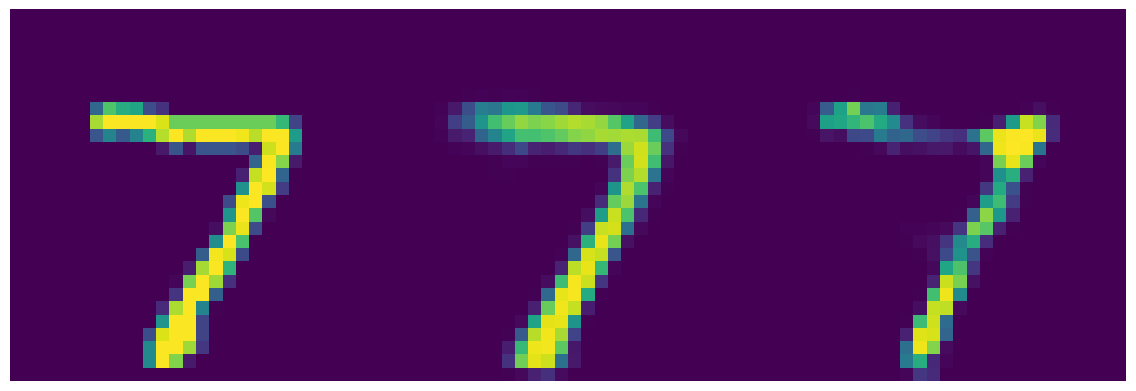

torch.Size([1, 784]) -> torch.Size([1, 16])


<Figure size 600x200 with 0 Axes>

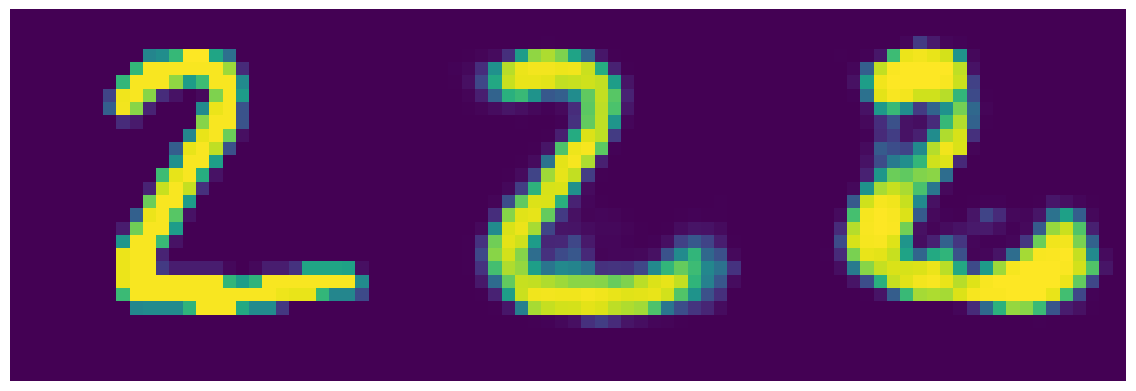

torch.Size([1, 784]) -> torch.Size([1, 16])


<Figure size 600x200 with 0 Axes>

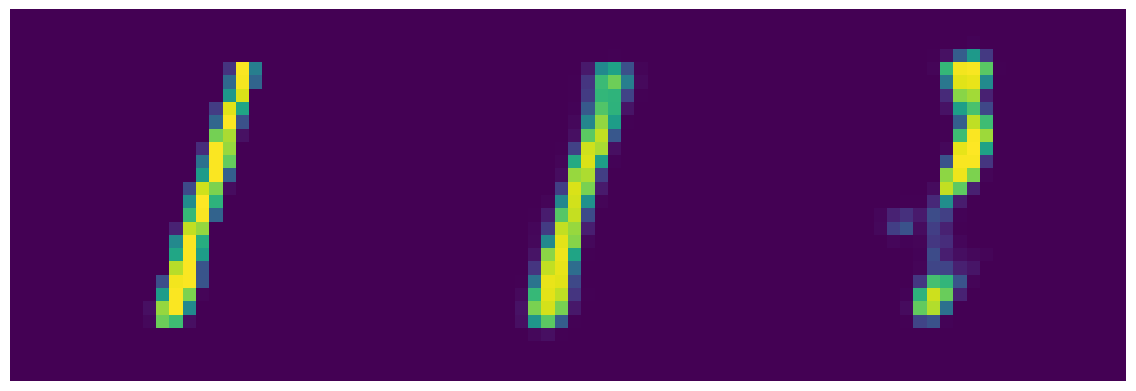

torch.Size([1, 784]) -> torch.Size([1, 16])


<Figure size 600x200 with 0 Axes>

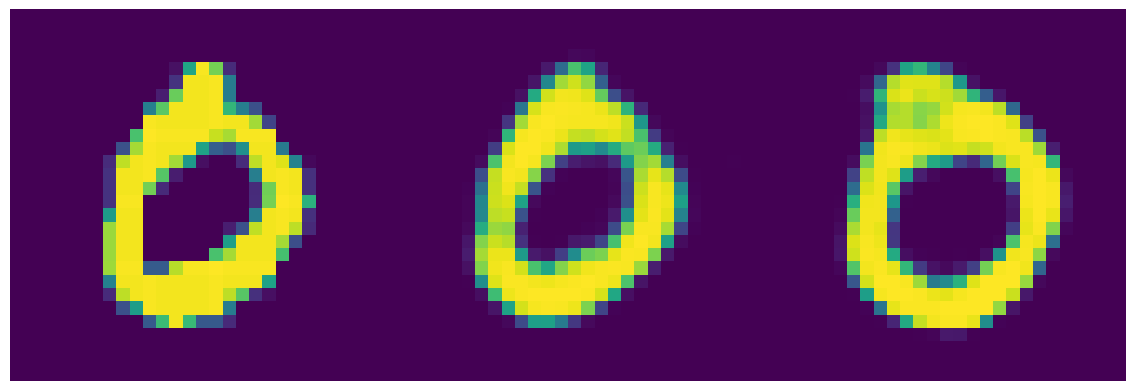

torch.Size([1, 784]) -> torch.Size([1, 16])


<Figure size 600x200 with 0 Axes>

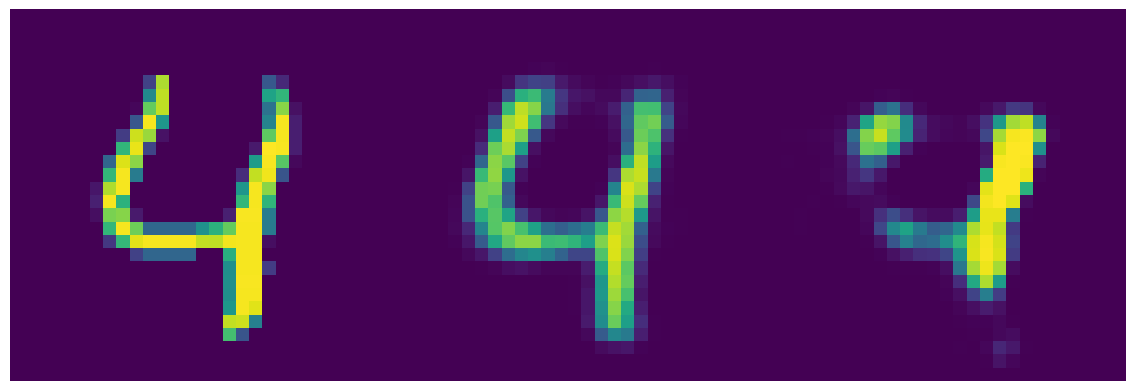

torch.Size([1, 784]) -> torch.Size([1, 16])


<Figure size 600x200 with 0 Axes>

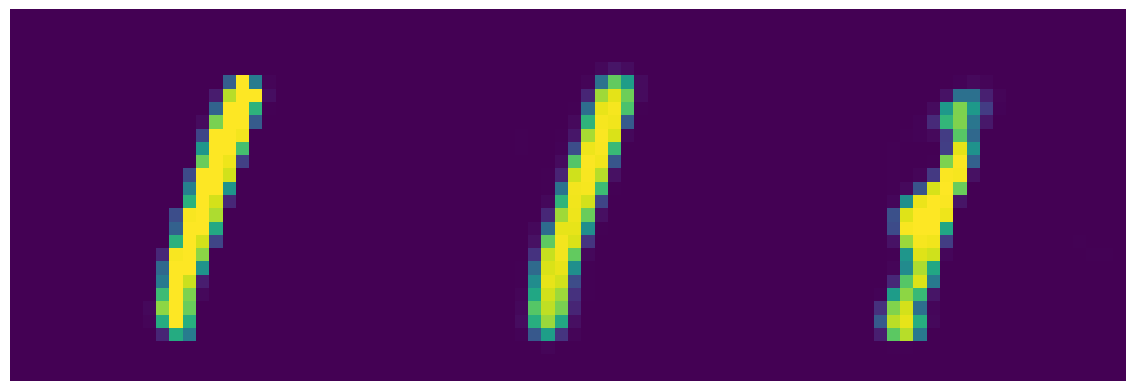

torch.Size([1, 784]) -> torch.Size([1, 16])


<Figure size 600x200 with 0 Axes>

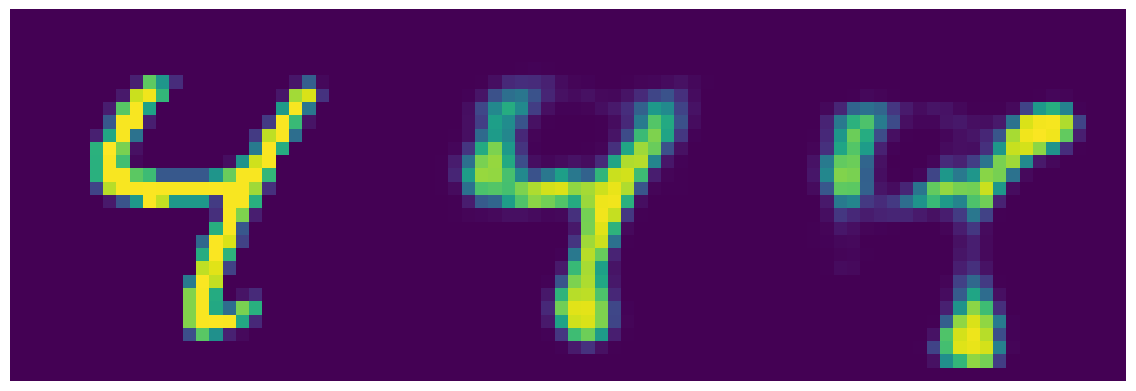

torch.Size([1, 784]) -> torch.Size([1, 16])


<Figure size 600x200 with 0 Axes>

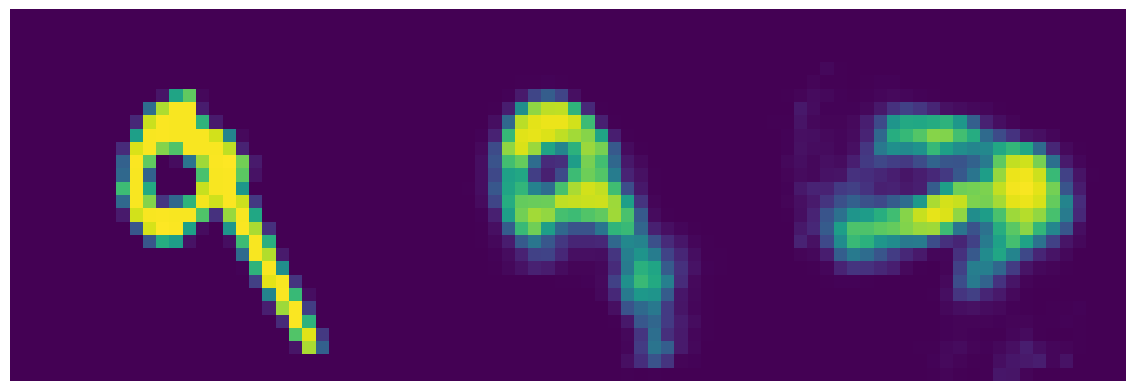

torch.Size([1, 784]) -> torch.Size([1, 16])


<Figure size 600x200 with 0 Axes>

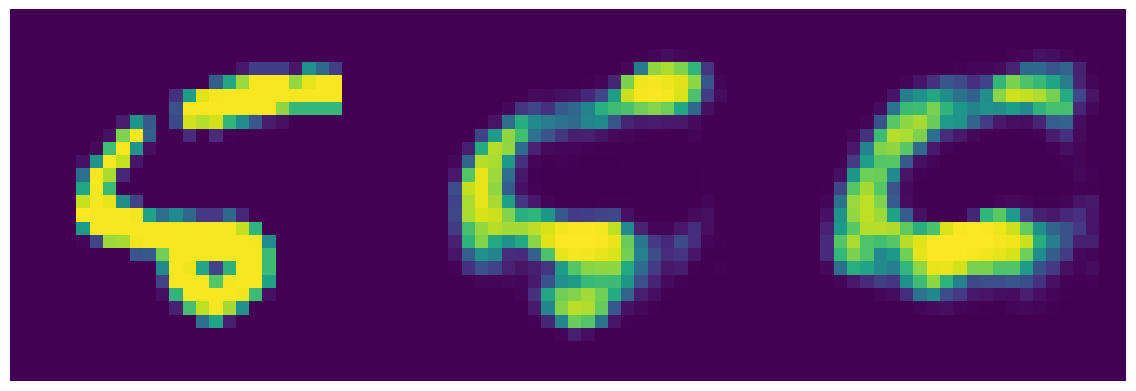

torch.Size([1, 784]) -> torch.Size([1, 16])


<Figure size 600x200 with 0 Axes>

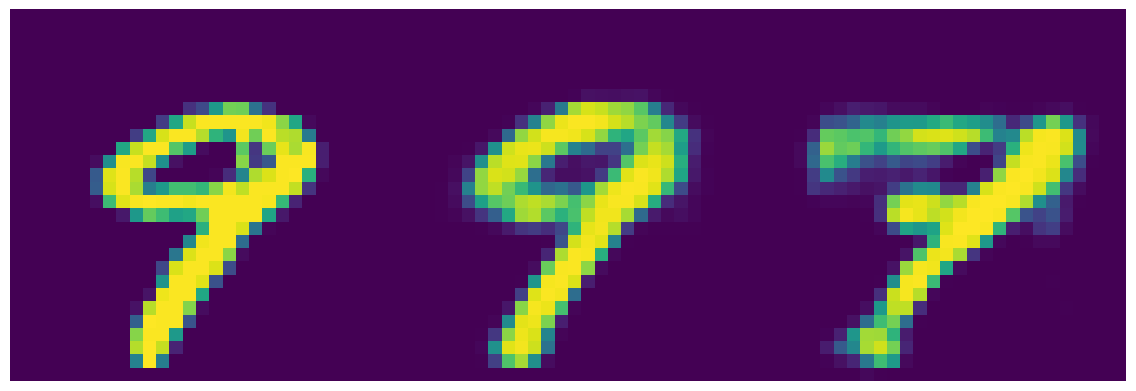

In [4]:
dataset = datasets.MNIST('../data', train=False, transform=transforms.ToTensor())

for i in range(10):

    #取一组数据
    raw = dataset[i][0].view(1,-1) #raw: bs,28,28->bs,28*28
    #用encoder压缩数据
    feat = model.encoder(raw.to('cuda'))
    #展示数据及维度
    print(raw.shape,'->',feat.shape)

    # 改动： 添加噪声
    feat_noise = torch.randn_like(feat)*3 + feat # TODO: You may increase the noise strength to distort the output more.
    
    output = model.decoder(feat).to('cpu')
    output_noise = model.decoder(feat_noise).to('cpu')
    
    #展示效果   
    #将测试步骤中的数据、重构数据绘图
    concat = torch.cat((raw.view(28, 28), output.view( 28, 28), output_noise.view( 28, 28)), 1)

    plt.figure(figsize=(6,2))
    plt.matshow(concat.cpu().detach().numpy())
    plt.axis('off')
    plt.show()